In [324]:
%matplotlib inline
import numpy as np
import jax
import jax.numpy as jnp
import einops
import equinox as eqx
import optax
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
import tqdm
import pprint

In [182]:
class LinearAutoencoder(eqx.Module):
    input_dim: int
    latent_dim: int
    W_in: jnp.ndarray
    b_in: jnp.ndarray
    W_out: jnp.ndarray
    b_out: jnp.ndarray
    lambdas: dict
    
    def __init__(self, input_dim, latent_dim, *, key):
        keys = iter(jax.random.split(key, 100))
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.W_in = jax.random.normal(next(keys), (latent_dim, input_dim))
        self.b_in = jnp.zeros((latent_dim,))
        self.W_out = jax.random.normal(next(keys), (input_dim, latent_dim))
        self.b_out = jnp.zeros((input_dim,))
        self.lambdas = {
            'reconstruct': 100,
            'nonnegative': 100,
            'weight_energy': 1,
            'latent_energy': 1
        }
        
    def encode(self, s):
        return self.W_in @ s + self.b_in
    
    def decode(self, z):
        return self.W_out @ z + self.b_out
        
    def batched_loss(self, model, s, *, key):
        z = jax.vmap(model.encode)(s)
        s_hat = jax.vmap(model.decode)(z)
        
        losses = {}
        losses['reconstruct'] = jnp.mean(einops.reduce((s_hat - s) ** 2, 'b d -> b', reduction='sum'))
        losses['nonnegative'] = jnp.mean(einops.reduce((0.5 * (z - jnp.abs(z))) ** 2, 'b d -> b', reduction='sum'))
        losses['weight_energy'] = einops.reduce(model.W_in ** 2, 'ds dz ->', reduction='sum') + einops.reduce(model.W_out ** 2, 'dz ds ->', reduction='sum')
        losses['latent_energy'] = jnp.mean(einops.reduce(z ** 2, 'b d -> b', reduction='sum'))
        losses['all'] = sum(model.lambdas[k] * v for k, v in losses.items())
        aux = {
            'losses': losses
        }
        return losses['all'], aux
    
@eqx.filter_jit
def train_step(model, optimizer_state, optimizer, s, *, key):
    (_, aux), grad = eqx.filter_value_and_grad(model.batched_loss, has_aux=True)(model, s, key=key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, model)
    model = eqx.apply_updates(model, update)
    return model, optimizer_state, aux

def train_model(s):
    key = jax.random.PRNGKey(42)

    model = LinearAutoencoder(2, 2, key=key)
    optimizer = optax.adam(3e-2)
    optimizer_state = optimizer.init(model)
    for _ in tqdm.trange(int(5e4)):
        key, subkey = jax.random.split(key)
        model, optimizer_state, aux = train_step(model, optimizer_state, optimizer, s, key=subkey)
        # if _ % 20000 == 0:
        #     pprint.pprint(aux['losses'])
    return model

In [183]:
data = {}
models = {}

In [184]:
step_size = 0.05

# generate grid of data
s = np.mgrid[-1:1.001:step_size, -1:1.001:step_size]
s = einops.rearrange(s, 'd x y -> (x y) d')
s_square = jnp.copy(s)

theta = jnp.pi / 4
R = jnp.array([
    [jnp.cos(theta), -jnp.sin(theta)],
    [jnp.sin(theta), jnp.cos(theta)]
])
x = einops.einsum(R, s, 'i j, n j -> n i')

data['square'] = x

# m = -1
# for b in [-1, -1.25, -1.5, -1.75, -1.95, -1.99, -1.999, -2]:
#     s = jnp.copy(s_square)
#     s = s[s[:, 1] > m * s[:, 0] + b - 0.0001]
#     data[f'line_{m}_{b}'] = jnp.copy(s)
# 
s = jnp.copy(s_square)
s = s[(s[:, 0] ** 2 + s[:, 1] ** 2) >= 0.75 ** 2]
x = einops.einsum(R, s, 'i j, n j -> n i')

data['cut_circle'] = x
# len(data['line_-1_-1.999']), len(data['line_-1_-2'])

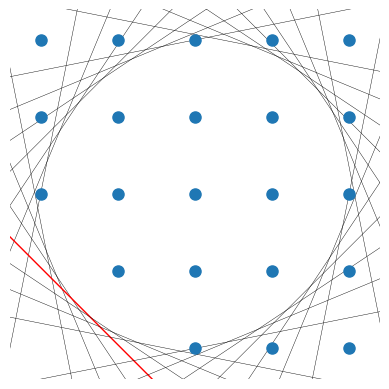

In [432]:
def plot(s, plot_red):
    s_bar = s - jnp.mean(s, axis=0)
    s_bar = s
    s_bar_min = jnp.min(s_bar, axis=0)
    s_bar_max = jnp.max(s_bar, axis=0)
    
    fig, ax = plt.subplots()
    ax.scatter(s_bar[:, 0], s_bar[:, 1], s=64)
    
    for theta in jnp.linspace(0, 2 * jnp.pi, 32, endpoint=False):
        w = jnp.array([jnp.cos(theta), jnp.sin(theta)])
        
        if jnp.abs(w[0]) < 1e-3 or jnp.abs(w[1]) < 1e-3:
            continue
        
        min_term = 0
        max_term = 0
        for j in range(2):
            min_term += (w[j] * s_bar_min[j]) ** 2
            max_term += (w[j] * s_bar_max[j]) ** 2
        
        extreme_term = min(min_term, max_term)
            
        corr_term = 0
        for j in range(2):
            for k in range(2):
                if j != k:
                    corr_term += w[j] * w[k] * jnp.mean(s_bar[:, j] * s_bar[:, k])
        energy = jnp.sqrt(extreme_term - corr_term)
        
        x_lim = jnp.min(s_bar[:, 0]) - 0.2, jnp.max(s_bar[:, 0]) + 0.2
        y_lim = jnp.min(s_bar[:, 1]) - 0.2, jnp.max(s_bar[:, 1]) + 0.2
        
        # draw line w[0] x + w[1] y = energy
        x = jnp.linspace(-100, 100, 1000)
        y = (energy - w[0] * x) / w[1]
        
        if jnp.isclose(theta, 5 * jnp.pi / 4, 0.03) and plot_red:
            ax.plot(x, y, 'red', linewidth=1, zorder=-1)
        else:
            ax.plot(x, y, 'black', linewidth=0.3, zorder=-1)

    ax.set_aspect('equal')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    # frame off
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

step_size = 0.5
s = np.mgrid[-1:1.001:step_size, -1:1.001:step_size]
s = einops.rearrange(s, 'd x y -> (x y) d')

# plot(s, plot_red=False)

m = -1
b = -1.2
s = s[s[:, 1] > m * s[:, 0] + b + 0.0001]
plot(s, plot_red=True)
# plt.savefig('slides2.png', bbox_inches='tight', dpi=300)

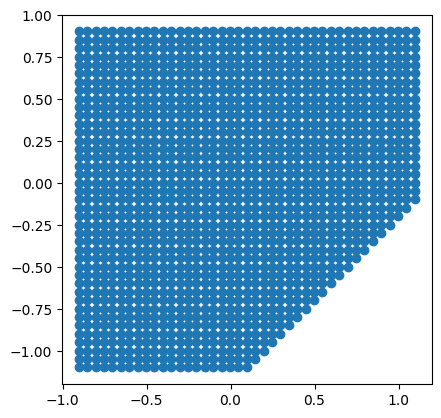

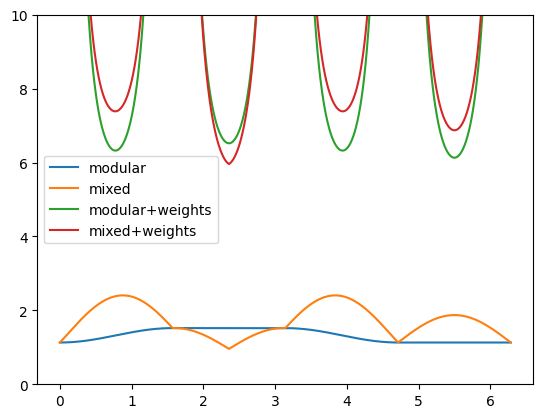

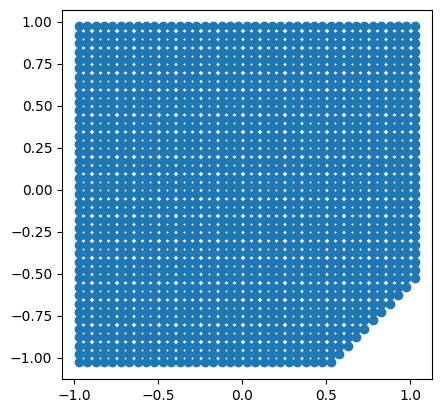

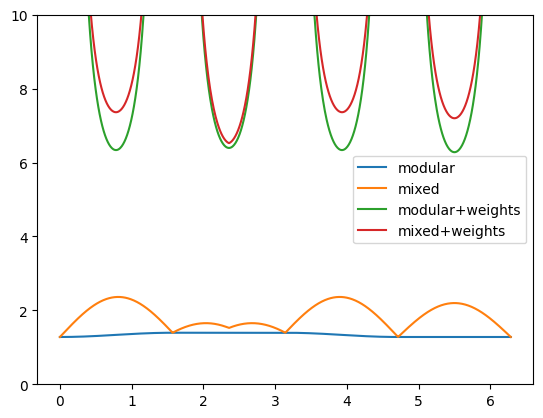

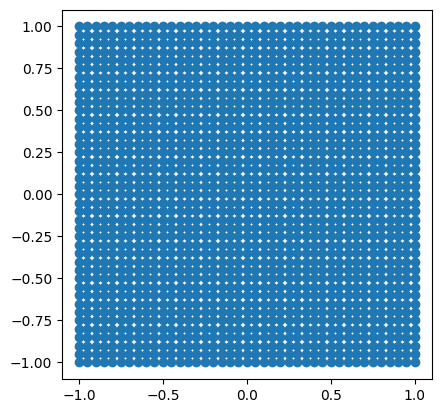

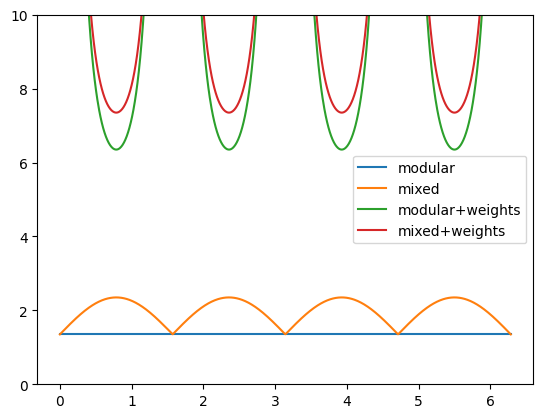

In [253]:
# generate grid of data
step_size = 0.05
s = np.mgrid[-1:1.001:step_size, -1:1.001:step_size]
s = einops.rearrange(s, 'd x y -> (x y) d')
s_square = jnp.copy(s)

# m = -1
# for b in [0, -0.5, -1, -1.5]:
m = 1
for b in [-1, -1.5, -2]:
    s = jnp.copy(s_square)
    s = s[s[:, 1] > m * s[:, 0] + b - 0.0001]
    
    s = s - jnp.mean(s, axis=0)
    
    fig, ax = plt.subplots()
    ax.scatter(s[:, 0], s[:, 1])
    ax.set_aspect('equal')
    
    thetas = []
    modulars = []
    mixeds = []
    weights = []
    
    for theta in jnp.linspace(0, 2 * jnp.pi, 1000):
        w = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    
        b_mixed = -jnp.min(einops.einsum(w, s, 'd, n d -> n'))
        z_mixed = einops.einsum(w, s, 'd, n d -> n') + b_mixed
        
        assert 0 <= jnp.min(z_mixed) <= 1e-4
        
        mixed_energy = einops.reduce(z_mixed ** 2, 'n ->', reduction='mean')
        
        b_modular = -jnp.min(einops.einsum(w, s, 'd, n d -> n d'), axis=0)
        z_modular = einops.einsum(w, s, 'd, n d -> n d') + b_modular
        assert 0 <= jnp.min(z_modular[:, 0]) <= 1e-4
        assert 0 <= jnp.min(z_modular[:, 1]) <= 1e-4
        
        modular_energy = einops.reduce(einops.reduce(z_modular ** 2, 'n d -> n', reduction='sum'), 'n ->', reduction='mean')
        
        thetas.append(theta)
        modulars.append(modular_energy)
        mixeds.append(mixed_energy)
        
        weights.append(w[0] ** 2 + w[1] ** 2 + (1 / w[0]) ** 2 + (1 / w[1]) ** 2)
    
    thetas = jnp.array(thetas)
    modulars = jnp.array(modulars)
    mixeds = jnp.array(mixeds)
    weights = jnp.array(weights)
    fig, ax = plt.subplots()
    ax.plot(thetas, modulars, label='modular')
    ax.plot(thetas, mixeds, label='mixed')
    ax.plot(thetas, modulars + weights, label='modular+weights')
    ax.plot(thetas, mixeds + weights, label='mixed+weights')
    ax.set_ylim(0, 10)
    ax.legend()

Array([0.70655066, 0.70766246], dtype=float32)

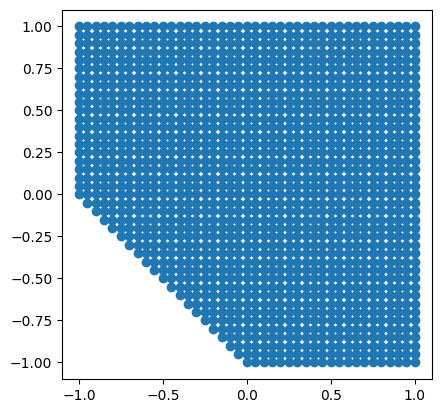

In [216]:
fig, ax = plt.subplots()
ax.scatter(s[:, 0], s[:, 1])
ax.set_aspect('equal')
i = jnp.argmin(jnp.array(mixeds))
theta = thetas[i]
w = jnp.array([jnp.cos(theta), jnp.sin(theta)])
w

In [207]:
mixed_energy, modular_energy

(Array(1.394193, dtype=float32), Array(1.35, dtype=float32))

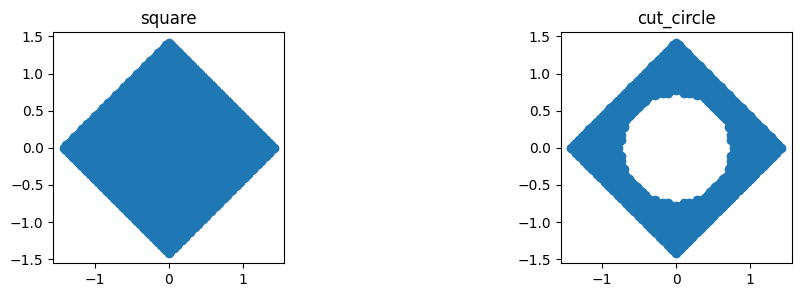

In [187]:
fig, axes = plt.subplots(1, len(data), figsize=(12, 3))
for i, (k, v) in enumerate(data.items()):
    ax = axes[i]
    ax.scatter(v[:, 0], v[:, 1])
    ax.set_title(k)
    ax.set_aspect('equal')

In [188]:
for k, v in data.items():
    models[k] = train_model(v)

100%|██████████| 50000/50000 [00:10<00:00, 4755.35it/s]


In [189]:
for k, v in models.items():
    pprint.pprint(k)
    pprint.pprint(v.W_in)

'square'
Array([[-0.57142544,  0.57083553],
       [-0.5708198 , -0.5714863 ]], dtype=float32)
'cut_circle'
Array([[-0.56189924,  0.5618991 ],
       [-0.56189984, -0.56189936]], dtype=float32)


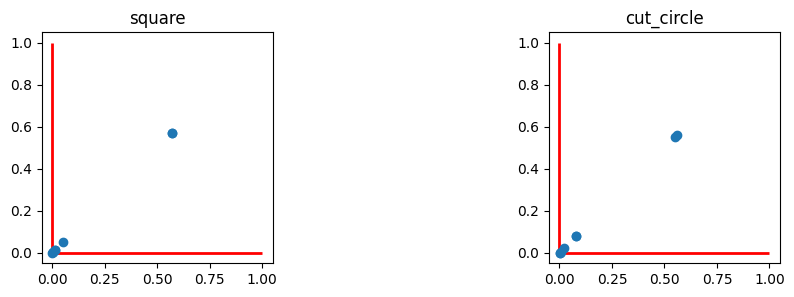

In [175]:
fig, axes = plt.subplots(1, len(models), figsize=(12, 3))
for i, (k, v) in enumerate(models.items()):
    ax = axes[i]
    ax.hlines(y=0, xmin=0, xmax=1, linewidth=2, color='r', zorder=0)
    ax.vlines(x=0, ymin=0, ymax=1, linewidth=2, color='r', zorder=0)
    ax.scatter(jnp.abs(v.W_in[:, 0]), jnp.abs(v.W_in[:, 1]))
    ax.set_title(k)
    ax.set_aspect('equal')


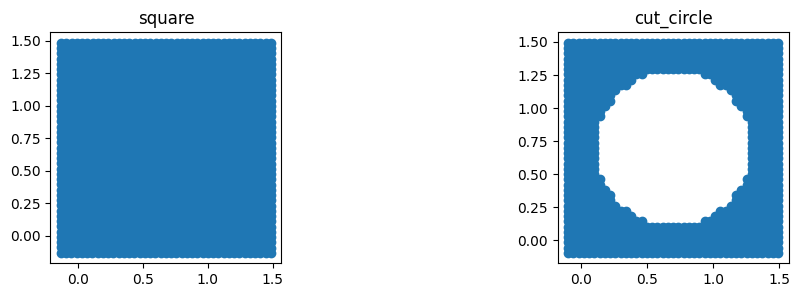

In [190]:
fig, axes = plt.subplots(1, len(models), figsize=(12, 3))
for i, (k, v) in enumerate(models.items()):
    ax = axes[i]
    s = data[k]
    z = jax.vmap(v.encode)(s)
    ax.scatter(z[:, 0], z[:, 1])
    ax.set_title(k)
    ax.set_aspect('equal')